# TESTE: Criar um modelo para estimar a qualidade de vinhos a partir de variáveis fisico-químicas e sensoriais 

In [174]:
# importando bibliotecas de uso geral
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pylab import rcParams

### Carregamento da base

In [175]:
winedb = pd.read_csv('winequality.csv',sep=';',decimal='.')
winedb.shape

(6497, 13)

In [176]:
winedb.head(8)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
5,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
6,White,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6
7,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6


### Análise de Consistência dos dados

In [177]:
winedb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
type                    6497 non-null object
fixed acidity           6497 non-null float64
volatile acidity        6497 non-null float64
citric acid             6497 non-null float64
residual sugar          6497 non-null float64
chlorides               6497 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null object
quality                 6497 non-null int64
dtypes: float64(10), int64(1), object(2)
memory usage: 659.9+ KB


In [178]:
# dados estão 100% preenchidos
winedb.columns.isnull().any()

False

In [179]:
winedb['type'].value_counts()*100/winedb['type'].shape[0]

White    75.388641
Red      24.611359
Name: type, dtype: float64

A base contem 12 variáveis sendo: 11 numéricas e 1 categórica ("type", referente ao tipo de vinho). O tipo de vinho com maior amostragem é o branco (75% da base). Um ponto a observar é que a variável numérica "alcohol" está sendo interpretada como não numérica (object). Para entender o motivo, podemos observar sua distribuição. 

In [180]:
winedb['alcohol'].value_counts().tail(15)

117.333.333.333.333    1
11.85                  1
8.0                    1
9.05                   1
13.55                  1
113.666.666.666.667    1
112.666.666.666.667    1
123.333.333.333.333    1
11.65                  1
923.333.333.333.333    1
10.98                  1
105.666.666.666.667    1
956.666.666.666.667    1
11.55                  1
14.2                   1
Name: alcohol, dtype: int64

Problema surge devido à ambiguidade na pontuação decimal. Como a porcentagem de álcool só pode assumir valores entre 0 e até 100%, uma observação de sua distribuição nos permite decidir entre (i) descartar estes dados ou (ii) inferir a pontuação e valores corretos.

In [181]:
#checar distribuicao de dados validos
pd.to_numeric(winedb['alcohol'],errors='coerse').describe()

count    6457.000000
mean       10.489083
std         1.192961
min         8.000000
25%         9.500000
50%        10.300000
75%        11.300000
max        14.900000
Name: alcohol, dtype: float64

In [182]:
#checar numero de casos com assinalamento incorreto de casas decimais
pd.to_numeric(winedb['alcohol'],errors='coerse').isnull().sum()

40

Para valores válidos (com um único separados decimal), encontramos valores para porcentagem de alcool em vinho distribuidos entre 8% e 14.9%. Além disso, somente 40 observações (0,6%) apresentam problemas na definição da posição da casa decimal. Uma vez que estes casos representam uma parcela ínfima do conjunto e que não é possível determinar com total certeza a posição da casa decimal e, consequentemente, o valor correto, decidiu-se por substituir estes casos pelo valor da mediana desta variável.

In [183]:
# substituindo inconsistências por NaN e preenchendo-os com a mediana
winedb['alcohol'] = pd.to_numeric(winedb['alcohol'],errors='coerse')
winedb['alcohol'].fillna(winedb['alcohol'].mean(),inplace=True)

Agora que temos a variável "alcohol" em sua forma numérica e devidamente preenchida, podemos checar se existem variáveis com valor constante (variância nula), que poderiam ser descartadas do conjunto.

Outro tratamento necessário das variáveis consiste em aplicar um tratamento em variáveis categóricas. Na base de estudo a única variável dentro desta classe é o tipo de vinho ('Red' ou 'White'). Uma análise inicial de dados estatísticos da distribuição de tipo de vinho não indica uma influência clara em sua qualidade. 

In [184]:
winedb.groupby('type')['quality'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
Red,1599.0,5.636023,0.807569,3.0,5.0,6.0,6.0,8.0
White,4898.0,5.877909,0.885639,3.0,5.0,6.0,6.0,9.0


Uma vez que só existem 2 categorias possíveis, esta variável pode ser substituída por apenas uma nova coluna com variável numérica com valores binários: 0 para vinho tinto (Red) e 1 para não tinto (White).

In [185]:
winedb['type_bin'] = pd.get_dummies(winedb['type'],drop_first=True)

In [186]:
# avaliacao de variância pelo desvio padrão
winedb.describe().loc['std',:]

fixed acidity            1.296434
volatile acidity         0.164636
citric acid              0.145318
residual sugar           4.757804
chlorides                0.035034
free sulfur dioxide     17.749400
total sulfur dioxide    56.521855
density                  7.636088
pH                       0.160787
sulphates                0.148806
alcohol                  1.189282
quality                  0.873255
type_bin                 0.430779
Name: std, dtype: float64

Portanto, não existem variáveis numéricas na base com variância nula, que poderiam ser descartadas.

### Análise exploratória das variáveis

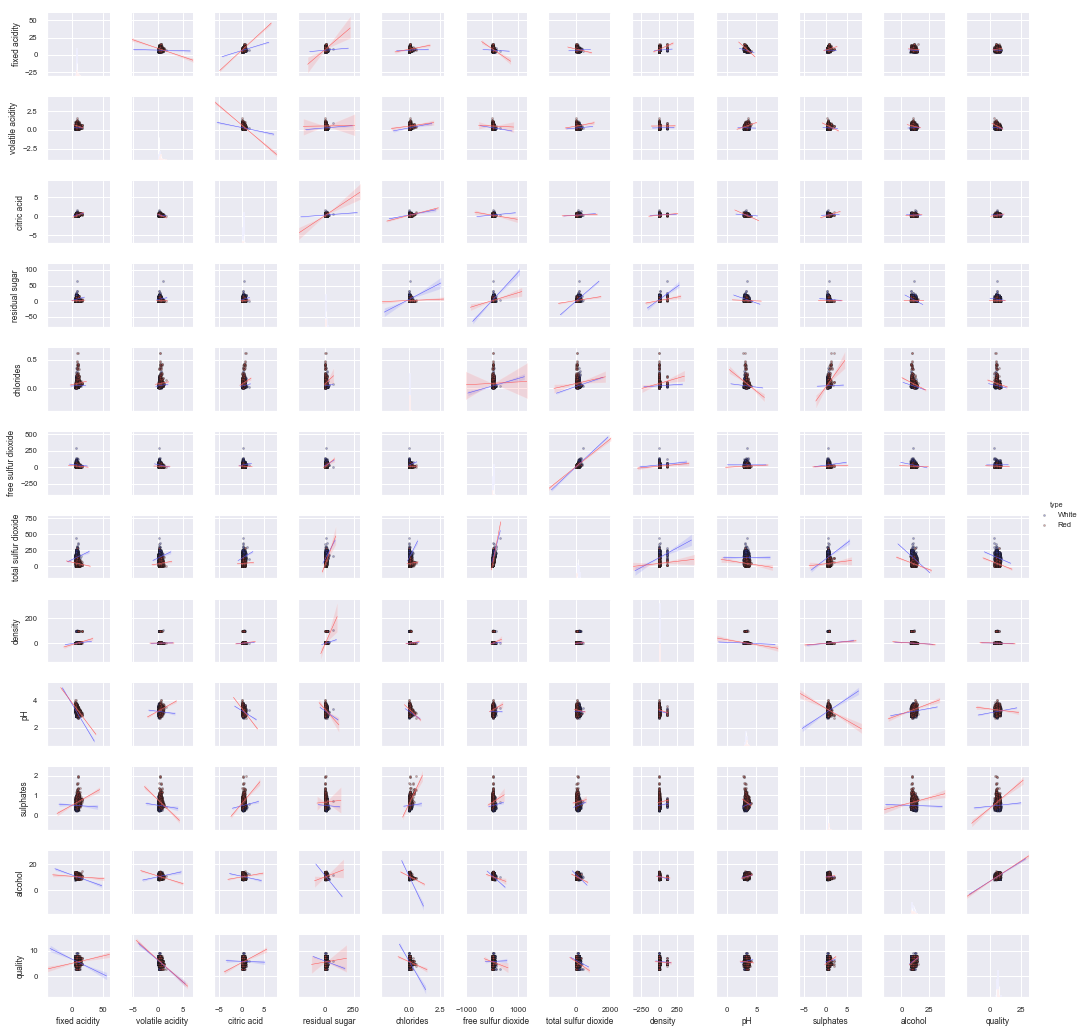

<Figure size 432x288 with 0 Axes>

In [187]:
# grafico para analise de dependencia entre variáveis e resposta de interesse
sns.set(font_scale=0.7)
fig.set_size_inches(12,12)
g = sns.pairplot(winedb.drop('type_bin',axis=1), 
                    hue = 'type', diag_kind = 'hist', diag_kws=dict(bins=12,alpha=0.8), palette="seismic",
                    plot_kws = {'scatter_kws':{'alpha': 0.3, 's': 3, 'edgecolor': 'k'},'line_kws':{'lw': 0.5}}, 
                    height=1.2 , kind='reg');
g.fig.get_children()[-1].set_bbox_to_anchor((1.0, 0.5, 0, 0))
g.savefig('distributions_bywinetype.png',dpi=200,bbox_inches='tight')
plt.show();
plt.gcf().clear;

Pelo gráfico de distribuição acima (também salvo como arquivo "distributions_bywinetype.png" no presente diretório) entre as variáveis do conjunto é possível observar, em uma primeira análise, uma considerável correlação linear entre a qualidade do vinho e principalmente as variáveis: 'volatilidade da acidez', 'cloretos', 'dióxido de enxofre total', 'sulfatos' e 'álcool'.

Uma análise mais aprofundada da dependência da variável resposta com outras variáveis pode ser obtida através do cálculo da correlação linear entre as distribuições de variáveis. Além disso, esta análise permite identificar variáveis muito relacionadas que podem proporcionar informações redundantes e gerar problemas de multicolinearidade na interpretação dos modelos. 

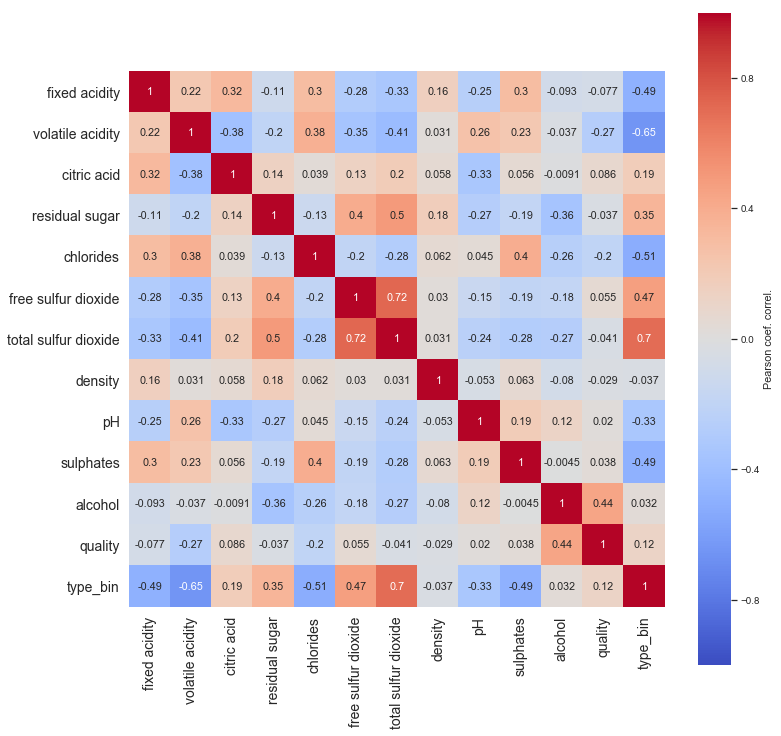

In [188]:
# Calculo de correlação linear (Pearson) entre variáveis numéricas para identificação de possíveis pares com informação similar e variáveis potenciais para predição da variável resposta
sns.set(font_scale=.9)
fig=plt.gcf()
fig.set_size_inches(12,12)
correl_heatmap = sns.heatmap(winedb.corr(),cmap='coolwarm',square=True,annot=True,vmin=-1.0, vmax=1.0,cbar_kws={'label': 'Pearson coef. correl.'})
correl_heatmap.set_yticklabels(correl_heatmap.get_yticklabels(), rotation = 0, fontsize = 14)
correl_heatmap.set_xticklabels(correl_heatmap.get_xticklabels(), rotation = 90, fontsize = 14)
correl_heatmap.get_figure().savefig('pearson_correlations_numvars_winequality.png',dpi=300,bbox_inches='tight')

A partir da análise quantitativa de correlações lineares por coeficiente de Pearson (r), é possível identificar e ordenar as principais variáveis que apresentam variação monotônica juntamente com a variável resposta de interesse (i.e. "quality"): (i) álcool: diretamente proporcional, (ii) volatilidade da acidez e (iii) cloretos : inversamente proporcional.

Para estas variáveis em especial, podemos explorar detalhadamente suas distribuições para diferentes qualidades de vinho.

In [ ]:
def prop_plot(prop,alvo='quality',pal="Blues"):
    sns.set(font_scale=2)
    sns.factorplot(y=alvo,x=prop,data=winedb,kind='bar',palette=pal,height=5,aspect=4,orient="h")
    sns.factorplot(y=alvo,x=prop,data=winedb,kind='box',palette=pal,height=5,aspect=4,orient="h")

### Comparacao entre nível de álcool e qualidade do vinho

In [ ]:
prop_plot('alcohol','quality')

### Comparacao entre volatilidade de acidez e qualidade do vinho

In [ ]:
prop_plot('volatile acidity','quality')

### Comparacao entre nível de cloretos e qualidade do vinho

In [ ]:
prop_plot('chlorides','quality')

A partir das análises apresentadas no gráfico acima é possível observar que vinhos classificados como de qualidade superior geralmente apresentam faixas mais estreitas de variação das propriedades físico-químicas avaliadas. Por exemplo, vinhos com score 9 em qualidade apresentam nível de cloretos limitados a uma faixa entre 2% a 3% e de álcool entre aproximadamente 12,5% e 13%.

### Avaliação da representatividade de dados por faixa de score

A distribuição da variável resposta do problema é apresentada na figura abaixo.

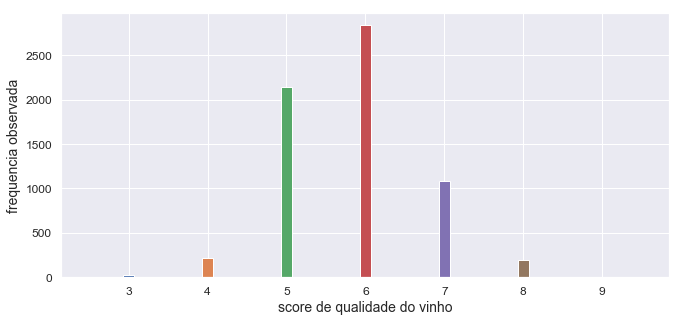

In [193]:
fig = plt.figure(figsize=(10,5))
plt.tick_params(labelsize=12)
plt.xlabel('score de qualidade do vinho',fontsize=14)
plt.ylabel('frequencia observada',fontsize=14)
winedb.groupby('quality')['quality'].hist(bins=len(winedb.groupby('quality').count().index));
plt.tight_layout()
plt.savefig('qualidade_vinho.png')
plt.gcf().clear;

Como pode-se observar no histograma acima, o conjunto de dados para score de qualidade de vinhos apresenta uma representatividade muito maior para vinhos "medianos" (com score entre 5 e 7) do que vinhos ruins (<5) e bons (>7). Esta baixa amostra em ambos os extremos de score do conjunto de dados pode ser um fator problemático para construção de modelos preditivos caso a densidade de pontos nesta região seja baixa, ao ponto de tornar para difícil para o modelo delinear uma região localizada do espaço amostral que corresponda à prevalência de uma faixa de score.

## Estudos de Modelagem e Inferência de Qualidade de Vinhos

### Caracterização do problema

O problema de classificação da qualidade de vinhos para o conjunto de dados apresentados apresenta uma característica em especial que o torna incomum quando comparado a outros problemas de Data Science usuais: 

##### a variável resposta a ser predita apresenta valores discretos (ou classes ordinais), resultando portanto em um problema de regressão ordinal.

ver: http://arxiv.org/abs/1408.2327

Dessa forma, tanto o tratamento deste sistema como um problema de classificação ou como de regressão não correspondem à abordagem correta, mas resultam somente em soluções aproximadas para construção de modelos preditivos. Ao tratar predição de valores ordinais como um problema de classificação, a natureza dos métodos de classificação exige que a ordem entre as múltiplas "classes" de score seja ignorada. Por outro lado, ao tratar o sistema como um problema de regressão, é nessário considerar que a escala de valores discretos seja uniforme. Ou seja, é necessário considerar que a "similaridade" ou os critérios para definição dos intervalos da escala da variável resposta seja homogênea e linearmente proporcional a uma escala contínua de valores. Apesar de em muitas aplicações práticas o uso de modelos de regressão se mostrar uma aproximação razoável e capaz de gerar resultados bastante satisfatórios, é preciso tomar bastante cuidado ao considerar que critérios de preferência atribuídos por humanos (como no caso da qualidade do vinho) são definidos de forma gradual e homogênea para incremento do score final.

### método de regressão ordinal
Devido às características do problema de classificação ordinal serem bastante específicas e ignoradas por muitos no desenvolvimento de modelos, como já descrito, o número de ferramentas de machine learning disponíveis é ainda bastante escasso. Tendo esta observação como justificativa, o método escolhido para este estudo foi o de regressão logística ordinal (all-threshold) proposto por Renniee Srebro (ver: https://ttic.uchicago.edu/~nati/Publications/RennieSrebroIJCAI05.pdf) e implementado na biblioteca MORD (https://pypi.org/project/mord/).

In [194]:
# importando bibliotecas de uso geral
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [195]:
# separando conjunto de features e variável resposta
winedb.drop('type',axis=1,inplace=True)
X = winedb.drop(['quality'],axis=1)
y = winedb['quality']

### Funcao com pipeline para otimização de parametros e teste com validação cruzada e hold-out

In [208]:
def oraculo(X,y,models,params):
    (X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=.1, stratify=y, random_state=3001)
    for k in models:
        pipeline = Pipeline([
        ('column', PowerTransformer()),
        ('model', k)])
        print('Estimador: ',k)
        grid = GridSearchCV(pipeline, params, scoring='neg_mean_absolute_error',
                                    n_jobs=-1, cv=3, verbose=1)
        grid.fit(X_train, y_train)
        pred = grid.best_estimator_.predict(X_test)
        print('Parameters of best model found: ')
        print(grid.best_params_)
        print('Mean Absolute Error: %1.4f' % (metrics.mean_absolute_error(y_test,pred)))
        print('Accuracy: %1.4f\n' % (metrics.accuracy_score(y_test,np.round(pred).astype(int))))
        print(metrics.classification_report(y_test,np.round(pred).astype(int)))
        print('\n\n')

## Estudo 1 - Regressão Ordinal - MORD

In [197]:
from mord import LogisticAT, LogisticIT # regressão ordinal a partir de pontos de corte
from mord import OrdinalRidge, LAD      # modelos de regressao adaptados para regressão ordinal

In [198]:
X.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'type_bin'],
      dtype='object')

#### Buscando e avaliando melhor modelo para cada um dos métodos de regressão ordinal selecionados

In [199]:
oraculo(X,y,[LogisticAT(),LogisticIT(),OrdinalRidge()],params = {'model__max_iter': np.linspace(10,110,11).astype(int),
                 'model__alpha': np.logspace(-2, 3, 6)})

Estimador:  LogisticAT(alpha=1.0, max_iter=1000, verbose=0)
Fitting 3 folds for each of 66 candidates, totalling 198 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 198 out of 198 | elapsed:  1.5min finished


Parameters of best model found: 
{'model__alpha': 1.0, 'model__max_iter': 40}
Mean Absolute Error: 0.4892
Accuracy: 0.5662

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        22
           5       0.63      0.56      0.59       214
           6       0.54      0.79      0.64       284
           7       0.60      0.23      0.33       108
           8       0.00      0.00      0.00        19

   micro avg       0.57      0.57      0.57       650
   macro avg       0.29      0.26      0.26       650
weighted avg       0.54      0.57      0.53       650




Estimador:  LogisticIT(alpha=1.0, max_iter=1000, verbose=0)
Fitting 3 folds for each of 66 candidates, totalling 198 fits


/Users/rnsantos/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rnsantos/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rnsantos/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 198 out of 198 | elapsed:  1.4min finished


Parameters of best model found: 
{'model__alpha': 0.10000000000000001, 'model__max_iter': 30}
Mean Absolute Error: 0.4969
Accuracy: 0.5615

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        22
           5       0.62      0.57      0.59       214
           6       0.53      0.78      0.63       284
           7       0.59      0.21      0.31       108
           8       0.00      0.00      0.00        19

   micro avg       0.56      0.56      0.56       650
   macro avg       0.29      0.26      0.26       650
weighted avg       0.53      0.56      0.52       650




Estimador:  OrdinalRidge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
       normalize=False, random_state=None, solver='auto', tol=0.001)
Fitting 3 folds for each of 66 candidates, totalling 198 fits


/Users/rnsantos/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rnsantos/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rnsantos/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 198 out of 198 | elapsed:   50.3s finished


Parameters of best model found: 
{'model__alpha': 100.0, 'model__max_iter': 10}
Mean Absolute Error: 0.4923
Accuracy: 0.5600

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        22
           5       0.64      0.52      0.58       214
           6       0.53      0.80      0.64       284
           7       0.59      0.22      0.32       108
           8       0.00      0.00      0.00        19

   micro avg       0.56      0.56      0.56       650
   macro avg       0.29      0.26      0.26       650
weighted avg       0.54      0.56      0.52       650






/Users/rnsantos/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rnsantos/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rnsantos/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


A partir da análise dos resultados obtidos com os modelos de regressão ordinal é possível constatar 2 pontos muito importantes: (i) os modelos gerados com os métodos de regressão ordinal selecionados não apresentaram capacidade preditiva elevada para estimar o score de qualidade de vinhos a partir da base disponibilizada, mesmo com um processo exaustivo de otimização de parâmetros e (ii) a avaliação separada das métricas para cada uma das faixas de score permitiu observar que os modelos apresentam uma razoável capacidade preditiva somente dentro de scores intermediários (5 a 7), mas é incapaz de prever valores em ambos os extremos da escala de qualidade. Uma possível causa desta limitação pode ser a esparsidade de dados nestas duas regiões limítrofes, como discutido ao final da análise exploratória.

A fim de investigar a influência da baixa amostragem de dados nas regiões limítrofes de score, um segundo teste foi executado com os mesmos modelos de regressão ordinal disponíveis na ferramenta MORD, porém agrupando scores de qualidade muito baixos com seus scores intermediários mais próximos, gerando uma faixa mais estreita de score. Dessa forma, scores abaixo de 5 para qualidade de vinhos (com baixo volume amostral) foram reclassificados como score 5 e observações com score acima de 7 foram também nivelados para um score de 7:

In [200]:
y_new = y.copy()
y_new[y_new<5]=5
y_new[y_new>7]=7

Text(0, 0.5, 'frequencia')

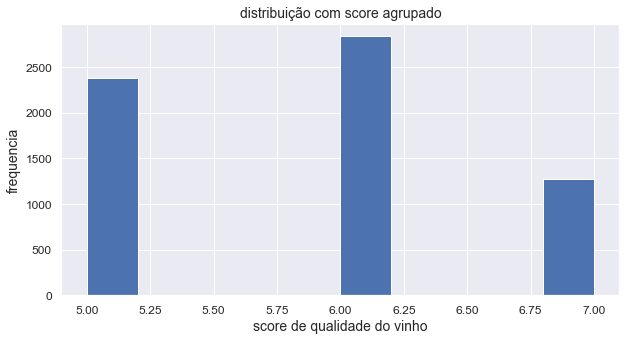

In [201]:
fig = plt.figure(figsize=(10,5))
plt.tick_params(labelsize=12)
y_new.hist()
plt.title('distribuição com score agrupado',fontsize=14)
plt.xlabel('score de qualidade do vinho',fontsize=14)
plt.ylabel('frequencia',fontsize=14)

#### Teste com segmentação de faixas de score

In [202]:
oraculo(X,y_new,[LogisticAT(), LogisticIT(),OrdinalRidge()],params = {'model__max_iter': np.linspace(10,110,11).astype(int),
                 'model__alpha': np.logspace(-2, 3, 6)})

Estimador:  LogisticAT(alpha=1.0, max_iter=1000, verbose=0)
Fitting 3 folds for each of 66 candidates, totalling 198 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 198 out of 198 | elapsed:   59.7s finished


Parameters of best model found: 
{'model__alpha': 10.0, 'model__max_iter': 20}
Mean Absolute Error: 0.4492
Accuracy: 0.5646

              precision    recall  f1-score   support

           5       0.67      0.55      0.61       238
           6       0.51      0.73      0.60       284
           7       0.58      0.22      0.32       128

   micro avg       0.56      0.56      0.56       650
   macro avg       0.59      0.50      0.51       650
weighted avg       0.58      0.56      0.55       650




Estimador:  LogisticIT(alpha=1.0, max_iter=1000, verbose=0)
Fitting 3 folds for each of 66 candidates, totalling 198 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 198 out of 198 | elapsed:   59.7s finished


Parameters of best model found: 
{'model__alpha': 100.0, 'model__max_iter': 20}
Mean Absolute Error: 0.4615
Accuracy: 0.5554

              precision    recall  f1-score   support

           5       0.64      0.61      0.62       238
           6       0.51      0.65      0.57       284
           7       0.54      0.23      0.33       128

   micro avg       0.56      0.56      0.56       650
   macro avg       0.56      0.50      0.51       650
weighted avg       0.56      0.56      0.54       650




Estimador:  OrdinalRidge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
       normalize=False, random_state=None, solver='auto', tol=0.001)
Fitting 3 folds for each of 66 candidates, totalling 198 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 198 out of 198 | elapsed:   52.3s finished


Parameters of best model found: 
{'model__alpha': 0.01, 'model__max_iter': 10}
Mean Absolute Error: 0.4677
Accuracy: 0.5385

              precision    recall  f1-score   support

           5       0.70      0.44      0.54       238
           6       0.49      0.82      0.61       284
           7       0.56      0.11      0.18       128

   micro avg       0.54      0.54      0.54       650
   macro avg       0.58      0.45      0.44       650
weighted avg       0.58      0.54      0.50       650






Os modelos obtidos aplicando os mesmos modelos para o novo conjunto com scores agrupados dentro de uma faixa de elevada amostragem não apresentaram uma melhora relevante quanto à capacidade preditiva, resultando ainda em modelos medianos. Este resultado nos leva a considerar as seguintes possibilidades: (i) o conjunto de dados apresenta baixa qualidade ou um conjunto de critérios inconsistente para atribuição de score de qualidade de vinhoh ou (ii) os modelos preditivos utilizados nestes estudos não possuem a complexidade necessária para identificar possíveis padrões não lineares intrínsicos do problema. Uma vez que a possíbilidade (i) resultaria em um impasse, resta a nós avaliar a possibilidade (ii) a partir de modelos com maior capacidade de identificar padrões não lineares. Uma vez que um conjunto de métodos mais sofisticados para problemas de regressão ordinal ainda são escassos pouco accessíveis, podemos testar a aproximação deste problema para um caso de classificação ou regressão, considerando as limitações discutidas anteriormente. Dessa forma, um modelo escolhido para estes novos estudos foi o de RandomForest (florestas aleatórias de árvores de decisão).

## Estudo 2 - Aproximação para caso de Regressão/Classificação

In [209]:
from sklearn.ensemble import RandomForestClassifier
models = [RandomForestClassifier()]
params = {'model__max_depth':range(3,12,2),'model__n_estimators':range(50,3051,300),
          'model__class_weight':['balanced'],'model__random_state':[42]}
oraculo(X, y,[RandomForestClassifier()],params)

Estimador:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Fitting 3 folds for each of 55 candidates, totalling 165 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
/Users/rnsantos/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/rnsantos/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/rnsantos/anaconda/lib/python3.5/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by

Parameters of best model found: 
{'model__n_estimators': 950, 'model__max_depth': 11, 'model__class_weight': 'balanced', 'model__random_state': 42}
Mean Absolute Error: 0.4031
Accuracy: 0.6415

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.45      0.23      0.30        22
           5       0.64      0.76      0.70       214
           6       0.69      0.58      0.63       284
           7       0.55      0.69      0.61       108
           8       0.73      0.58      0.65        19

   micro avg       0.64      0.64      0.64       650
   macro avg       0.51      0.47      0.48       650
weighted avg       0.64      0.64      0.64       650






/Users/rnsantos/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rnsantos/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rnsantos/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [205]:
from sklearn.ensemble import RandomForestRegressor
models = [RandomForestRegressor()]
params = {'model__max_depth':range(3,12,2),'model__n_estimators':range(50,3051,300),
         'model__random_state':[666]}
oraculo(X, y,models,params)

Estimador:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Fitting 3 folds for each of 55 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed: 60.2min finished


Parameters of best model found: 
{'model__n_estimators': 1250, 'model__max_depth': 11, 'model__random_state': 666}
Mean Absolute Error: 0.4659
Accuracy: 0.6462

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        22
           5       0.70      0.73      0.72       214
           6       0.63      0.76      0.69       284
           7       0.56      0.41      0.47       108
           8       1.00      0.11      0.19        19

   micro avg       0.65      0.65      0.65       650
   macro avg       0.48      0.34      0.34       650
weighted avg       0.63      0.65      0.62       650






/Users/rnsantos/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rnsantos/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rnsantos/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Os melhores modelos obtidos com o método de RandomForest tanto considerando a aproximação para um problema de classificação como regressão apresentaram resultados bastante superiores aos obtidos com a biblioteca MORD, com valores de acurácia subindo de 0,56 para 0,65 e erro de desvio médio absoluto (MAE) decaindo de aproximadamente 0,50 para 0,46.  Isto indica que a baixa capacidade dos métodos de regressão ordinal testados anteriormente em considerar relações não lineares para identificar padrões possa ser realmente um fator responsável pela limitação dos modelos preditivos anteriormente gerado. Além disso, estes resultados sugerem uma consistência e monotonicidade na atribuição de score para qualidade de vinhos.

Finalmente, para avaliar mais a fundo a necessidade de considerar dependencias de elevada complexidade entre as variáveis do problema, novos modelos foram gerados pela aplicação do método de gradient boosting, que corresponde atualmente a uma das ferramentas mais eficientes de machine-learning para extração de padrões e geração de modelos de elevada capacidade preditiva a partir de múltiplos níveis de complexidade.

## Estudo 3 - Utilizando método de regressão com Gradient Boosting

In [206]:
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor
params = {'model__max_depth':range(2,4),'model__n_estimators':range(50,951,100),
          'model__learning_rate':np.logspace(-3,-1,3),'model__random_state':[42]}
oraculo(X, y,[GradientBoostingClassifier(),GradientBoostingRegressor()],params)

Estimador:  GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 40.7min finished


Parameters of best model found: 
{'model__n_estimators': 950, 'model__max_depth': 3, 'model__random_state': 42, 'model__learning_rate': 0.10000000000000001}
Mean Absolute Error: 0.3831
Accuracy: 0.6662

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.54      0.32      0.40        22
           5       0.70      0.72      0.71       214
           6       0.66      0.73      0.69       284
           7       0.67      0.51      0.58       108
           8       0.53      0.47      0.50        19

   micro avg       0.67      0.67      0.67       650
   macro avg       0.52      0.46      0.48       650
weighted avg       0.66      0.67      0.66       650




Estimador:  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_spl

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

Como é possível observar a partir dos resultados acima, o método de gradient boosting permitiu obter um modelo com capacidade preditiva superior a todas as técnicas implementadas anteriormente. O melhor modelo encontrado apresenta valores de MAE e acurácia bastante satisfatórios (considerando as particularidades do sistema) de 0,38 e 0,67, respectivamente.